In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6400 # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.135990
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.398644
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.341906
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.872615
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.264237


In [7]:
#Data stored in UTC time, subtract 4 hours for EDT
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.135990,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.398644,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.341906,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.872615,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.264237,2010-04-16 22:19:01,22,pm,Fri


In [8]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [9]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

In [10]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [9]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [11]:
# Convert categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

In [12]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [13]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [14]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [15]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [16]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [17]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [18]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [19]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [20]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1360],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3986],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3419],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8726],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2642]])

In [21]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [22]:
cats.shape

torch.Size([120000, 3])

In [23]:
conts.shape

torch.Size([120000, 6])

In [24]:
y.shape

torch.Size([120000, 1])

In [27]:
# Set Embedding sizes for categorical columns
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [35]:
class Model(nn.Module):

    def __init__(self, emb_sizes, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        
        layerlist = nn.ModuleList()
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [36]:
model = Model(emb_sizes, conts.shape[1], 1, [200,100], p=0.3)

In [30]:
model

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [37]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [33]:
len(cat_train)

48000

In [34]:
len(cat_test)

12000

Note training takes approximately 30 minutes

In [39]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.53611088
epoch:  26  loss: 11.68825150
epoch:  51  loss: 10.55350018
epoch:  76  loss: 9.53049660
epoch: 101  loss: 8.70867443
epoch: 126  loss: 7.73901510
epoch: 151  loss: 6.58695793
epoch: 176  loss: 5.30887318
epoch: 201  loss: 4.16533613
epoch: 226  loss: 3.51483631
epoch: 251  loss: 3.38503957
epoch: 276  loss: 3.32647467
epoch: 300  loss: 3.30012012

Duration: 723 seconds


Thus predicting with an error of +- $3.30

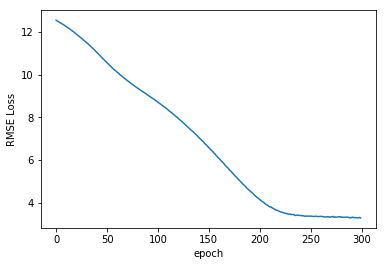

In [40]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [41]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.25888848


<h4>Error of +- $3.25 on testing data</h4>

In [42]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')